In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")

import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Flatten)
from tensorflow.keras.layers import (Dense, Lambda, Dropout, Activation)

from tensorflow.keras.layers import (Conv2D, MaxPooling2D)
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
STYLES_CSV_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"
IMAGES_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"

In [3]:
df = pd.read_csv(STYLES_CSV_PATH, error_bad_lines = False, warn_bad_lines=False)
print(f"Total Rows: {df.shape[0]}\nTotal Columns: {df.shape[1]}")
df.head()

Total Rows: 44424
Total Columns: 10


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
print('NaN Count:')
df.isna().sum()

NaN Count:


id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [5]:
df = df.dropna()
df = df.drop(['year', 'productDisplayName', 'masterCategory', 'subCategory'], axis=1)
df = df.sample(10000)
df = df[df['id'].isin([int(i.split('.')[0]) for i in os.listdir(IMAGES_PATH)])]

# Pre-processing

Adding `.jpg` to id column

In [6]:
df['id'] = df['id'].apply(lambda x: IMAGES_PATH+str(x) +'.jpg')
image_ids = df.pop('id')

Binning values with < 50 samples

In [7]:
def bin_values(x):
    x_vc = df[x].value_counts()
    x_other = x_vc[x_vc<50].index
    df.loc[df[x].isin(x_other),x] = 'Other'
    
for col in df.columns:
    bin_values(col)

Load Images

In [8]:
from keras.applications.resnet import preprocess_input

IMAGE_DIMS = (60, 60, 3)

def load_image(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image

image_data = []
for img_path in tqdm(image_ids):
    image_data.append(load_image(img_path))
    
image_data = np.array(image_data, dtype="float")

Using TensorFlow backend.
100%|██████████| 9999/9999 [07:15<00:00, 22.94it/s]


Load other features

In [9]:
articleTypeLB = LabelBinarizer()
genderLB = LabelBinarizer()
baseColourLB = LabelBinarizer()
seasonLB = LabelBinarizer()
usageLB = LabelBinarizer()

articleTypeLabels = articleTypeLB.fit_transform(np.array(df['articleType'].values))
genderLabels = genderLB.fit_transform(np.array(df['gender'].values))
baseColourLabels = baseColourLB.fit_transform(np.array(df['baseColour'].values))
seasonLabels = seasonLB.fit_transform(np.array(df['season'].values))
usageLabels = usageLB.fit_transform(np.array(df['usage'].values))

split = train_test_split(image_data,
                         articleTypeLabels, 
                         genderLabels, 
                         baseColourLabels, 
                         seasonLabels, 
                         usageLabels, 
                         test_size=0.2, random_state=42)

(trainX, testX,
 trainArticleTypeY, testArticleTypeY,
 trainGenderY, testGenderY,
 trainBaseColourY, testBaseColourY,
 trainSeasonY, testSeasonY,
 trainUsageY, testUsageY) = split

In [10]:
from tensorflow.keras.applications import ResNet50

In [11]:
def make_branch(res_input, n_out, act_type, name):
    z = Dense(512, activation="relu")(res_input)
    z = Dense(256, activation='relu')(z)
    z = Dense(128, activation='relu')(z)
#     z = BatchNormalization()(z)
#     z = Dropout(0.5)(z)
    z = Dense(n_out)(z)
    z = Activation(act_type, name=name+'_output')(z)
    return z

In [12]:
def build_model(width, height):

    # -------------------------
    res50 = ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_DIMS)
    res50.trainable=False
    inputs = Input(shape=IMAGE_DIMS)
    x = res50(inputs, training=False)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    # -------------------------

    article_branch = make_branch(x, len(articleTypeLB.classes_), 'softmax', 'article')
    gender_branch = make_branch(x, len(genderLB.classes_), 'softmax', 'gender')
    color_branch = make_branch(x, len(baseColourLB.classes_), 'softmax', 'color')
    season_branch = make_branch(x, len(seasonLB.classes_), 'softmax', 'season')
    usage_branch = make_branch(x, len(usageLB.classes_), 'softmax', 'usage')

    model = Model(inputs=inputs,
                outputs=[article_branch, gender_branch, color_branch, 
                            season_branch, usage_branch])
    return model

In [13]:
model = build_model(60, 60)

losses = {
    "article_output": "categorical_crossentropy",
    "gender_output": "categorical_crossentropy",
    "color_output": "categorical_crossentropy",
    "season_output": "categorical_crossentropy",
    "usage_output": "categorical_crossentropy",
}

EPOCHS = 25
INIT_LR = 1e-5
BS = 32

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, metrics=["accuracy"])

94773248/94765736 [==============================] - 6s 0us/step


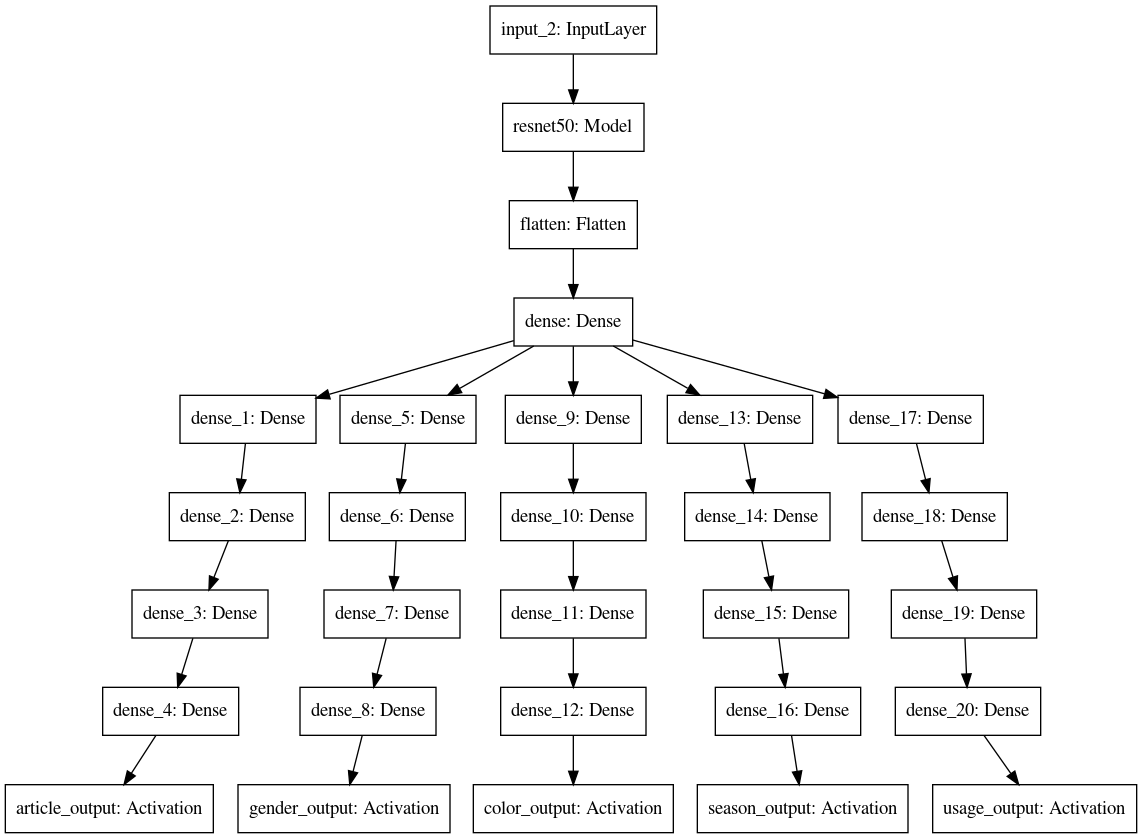

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [15]:
H = model.fit(trainX,
    {"article_output": trainArticleTypeY,
    "gender_output": trainGenderY,
    "color_output": trainBaseColourY,
    "season_output": trainSeasonY,
    "usage_output": trainUsageY},
    validation_data=(testX, 
    {"article_output": testArticleTypeY,
    "gender_output": testGenderY,
    "color_output": testBaseColourY,
    "season_output": testSeasonY,
    "usage_output": testUsageY}),
    epochs=EPOCHS,
    batch_size=BS,
    verbose=1)

Train on 7999 samples, validate on 2000 samples
Epoch 1/25
7999/7999 [==============================] - 16s 2ms/sample - loss: 8.3228 - article_output_loss: 2.7408 - gender_output_loss: 0.8330 - color_output_loss: 2.8569 - season_output_loss: 1.1204 - usage_output_loss: 0.7715 - article_output_accuracy: 0.3152 - gender_output_accuracy: 0.6720 - color_output_accuracy: 0.2463 - season_output_accuracy: 0.5147 - usage_output_accuracy: 0.7653 - val_loss: 6.5167 - val_article_output_loss: 1.9785 - val_gender_output_loss: 0.6609 - val_color_output_loss: 2.3696 - val_season_output_loss: 0.9403 - val_usage_output_loss: 0.5628 - val_article_output_accuracy: 0.4965 - val_gender_output_accuracy: 0.7515 - val_color_output_accuracy: 0.3520 - val_season_output_accuracy: 0.5815 - val_usage_output_accuracy: 0.8180
Epoch 2/25
7999/7999 [==============================] - 7s 838us/sample - loss: 5.6832 - article_output_loss: 1.6358 - gender_output_loss: 0.5803 - color_output_loss: 2.1107 - season_output_l

In [16]:
# %matplotlib inline
h_df = pd.DataFrame(H.history)
h_df.loc[:,[col for col in h_df.columns if 'accuracy' in col and 'val' not in col]].plot()
h_df.loc[:,[col for col in h_df.columns if 'accuracy' in col and 'val' in col]].plot()
h_df.loc[:,[col for col in h_df.columns if 'loss' in col and 'val' not in col]].plot()
h_df.loc[:,[col for col in h_df.columns if 'loss' in col and 'val' in col]].plot()

In [17]:
res = model.evaluate(testX, 
    {"article_output": testArticleTypeY,
    "gender_output": testGenderY,
    "color_output": testBaseColourY,
    "season_output": testSeasonY,
    "usage_output": testUsageY}, batch_size=32, verbose=0)
print('loss', res[:6])
print('acc', list(map(lambda x: round(x*100,2), res[6:])))

loss [4.722928461074829, 0.853572, 0.6098622, 1.7600615, 1.0038972, 0.48714453]
acc [76.2, 84.2, 53.6, 67.35, 87.25]


In [18]:
idx=3

(categoryProba, genderProba, ageProba, colorProba, styleProba) = model.predict(np.expand_dims(testX[idx], axis=0))

categoryIdx = categoryProba[0].argmax()
genderIdx = genderProba[0].argmax()
ageIdx = ageProba[0].argmax()
colorIdx = colorProba[0].argmax()
styleIdx = styleProba[0].argmax()
categoryLabel = articleTypeLB.classes_[categoryIdx]
genderLabel = genderLB.classes_[genderIdx]
ageLabel = baseColourLB.classes_[ageIdx]
colorLabel = seasonLB.classes_[colorIdx]
styleLabel = usageLB.classes_[styleIdx]

categoryText = "Category: {} ({:.2f}%)".format(categoryLabel, categoryProba[0][categoryIdx] * 100)
genderText = "Gender: {} ({:.2f}%)".format(genderLabel, genderProba[0][genderIdx] * 100)
ageText = "Age: {} ({:.2f}%)".format(ageLabel, ageProba[0][ageIdx] * 100)
colorText = "Color: {} ({:.2f}%)".format(colorLabel, colorProba[0][colorIdx] * 100)
styleText = "Style: {} ({:.2f}%)".format(styleLabel, styleProba[0][styleIdx] * 100)

print(categoryText, '-----', articleTypeLB.classes_[testArticleTypeY[idx].argmax()])
print(genderText, '-----',genderLB.classes_[testGenderY[idx].argmax()])
print(ageText, '-----',baseColourLB.classes_[testBaseColourY[idx].argmax()])
print(colorText, '-----',seasonLB.classes_[testSeasonY[idx].argmax()])
print(styleText, '-----',usageLB.classes_[testUsageY[idx].argmax()])

Category: Handbags (100.00%) ----- Handbags
Gender: Women (94.88%) ----- Women
Age: Black (99.49%) ----- Black
Color: Summer (85.33%) ----- Summer
Style: Casual (100.00%) ----- Casual
